In [1]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/scratch/imb/Xiao/.conda/envs/tensorflow_old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/imb/Xiao/.conda/envs/tensorflow_old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/imb/Xiao/.conda/envs/tensorflow_old/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
DATA_DIR = "/clusterdata/uqxtan9/Xiao/unet"

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'training_dataset_he_tile')
y_train_dir = os.path.join(DATA_DIR, 'training_dataset_anno_tile')

x_valid_dir = os.path.join(DATA_DIR, 'valid_dataset_he_tile')
y_valid_dir = os.path.join(DATA_DIR, 'valid_dataset_anno_tile')

x_test_dir = os.path.join(DATA_DIR, 'testing_dataset_he_tile')
y_test_dir = os.path.join(DATA_DIR, 'testing_dataset_anno_tile')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["background", "healthy_cortex","damaged_cortex","hippocampal_region",
               "dentate_gyrus","thalamus","cerebral_nuclei","corpus_callosum",
               "fornix","lateral_ventricle","anterior_commissure","medial_habenula",
               "lateral_habenula"]
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
        
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [5]:
classes = ["background", "healthy_cortex","damaged_cortex","hippocampal_region",
               "dentate_gyrus","thalamus","cerebral_nuclei","corpus_callosum",
               "fornix","lateral_ventricle","anterior_commissure","medial_habenula",
               "lateral_habenula"]

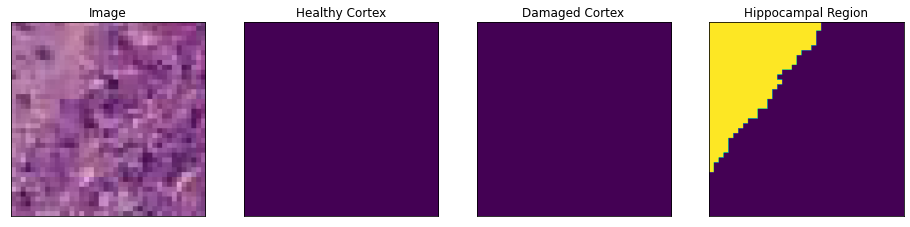

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    healthy_cortex=mask[..., 1].squeeze(),
    damaged_cortex=mask[..., 2].squeeze(),
    hippocampal_region=mask[..., 3].squeeze()
)

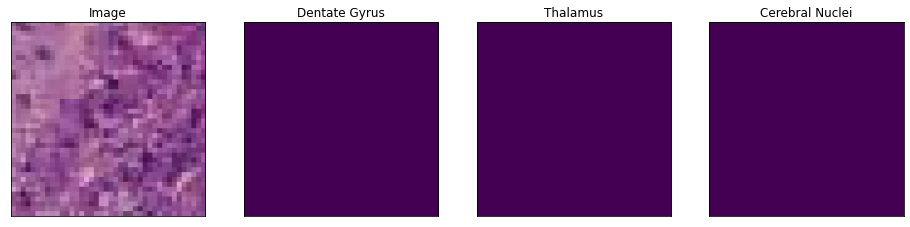

In [7]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    dentate_gyrus=mask[..., 4].squeeze(),
    thalamus=mask[..., 5].squeeze(),
    cerebral_nuclei=mask[..., 6].squeeze()
)

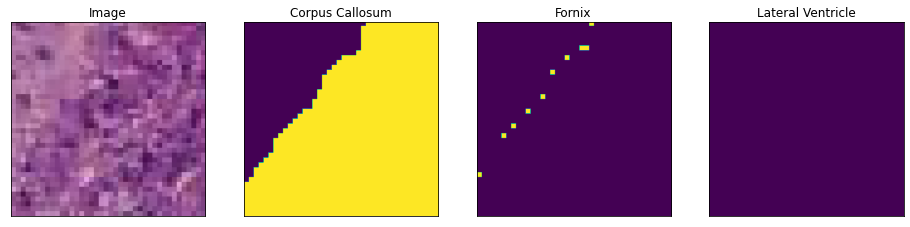

In [8]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    corpus_callosum=mask[..., 7].squeeze(),
    fornix=mask[..., 8].squeeze(),
    lateral_ventricle=mask[..., 9].squeeze()
)

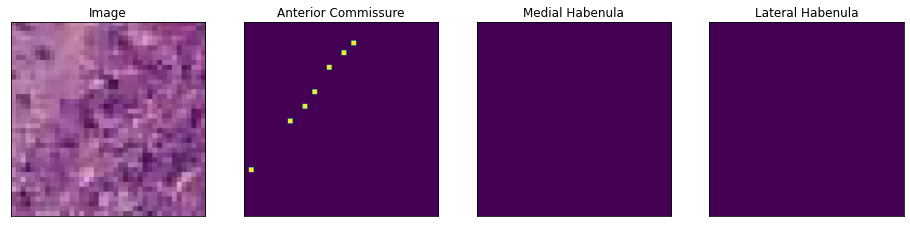

In [9]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    anterior_commissure=mask[..., 10].squeeze(),
    medial_habenula=mask[..., 11].squeeze(),
    lateral_habenula=mask[..., 12].squeeze()
)

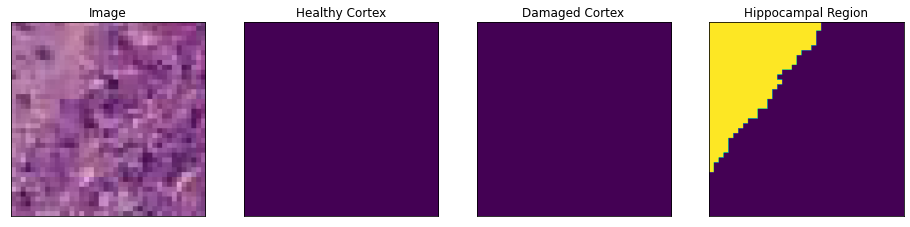

In [10]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    healthy_cortex=mask[..., 1].squeeze(),
    damaged_cortex=mask[..., 2].squeeze(),
    hippocampal_region=mask[..., 3].squeeze()
)

In [11]:
import albumentations as A

In [12]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(320, 320)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [24]:
import segmentation_models as sm

In [94]:
BACKBONE = 'resnet50'
BATCH_SIZE = 32
CLASSES = classes
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [96]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, input_shape=(320, 320, 3))

In [27]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 2, 2,2,1,2,1,1,1,1,1,1,1,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
from tensorflow.keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model, gpus=4, cpu_merge=False)
# compile keras model with defined optimozer, loss and metrics
parallel_model.compile(optim, total_loss, metrics)


ValueError: To call `multi_gpu_model` with `gpus=4`, we expect the following devices to be available: ['/cpu:0', '/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']. However this machine only has: ['/cpu:0', '/gpu:0']. Try reducing `gpus`.

In [97]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 2, 2,2,1,2,1,1,1,1,1,1,1,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [98]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_10epoch.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]


In [99]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
65/65 [==============================] - 145s 2s/step - loss: 0.9385 - iou_score: 0.1904 - f1-score: 0.1997 - val_loss: 0.9837 - val_iou_score: 0.8465 - val_f1-score: 0.8517
Epoch 2/10
65/65 [==============================] - 125s 2s/step - loss: 0.8687 - iou_score: 0.2801 - f1-score: 0.3061 - val_loss: 0.9782 - val_iou_score: 0.8702 - val_f1-score: 0.8764
Epoch 3/10
65/65 [==============================] - 135s 2s/step - loss: 0.8348 - iou_score: 0.3074 - f1-score: 0.3339 - val_loss: 0.9601 - val_iou_score: 0.8782 - val_f1-score: 0.8825
Epoch 4/10
65/65 [==============================] - 133s 2s/step - loss: 0.7936 - iou_score: 0.3338 - f1-score: 0.3690 - val_loss: 0.9511 - val_iou_score: 0.8745 - val_f1-score: 0.8791
Epoch 5/10
65/65 [==============================] - 132s 2s/step - loss: 0.7664 - iou_score: 0.3440 - f1-score: 0.3855 - val_loss: 0.9546 - val_iou_score: 0.8761 - val_f1-score: 0.8805
Epoch 6/10
65/65 [==============================] - 132s 2s/step - loss: 0.

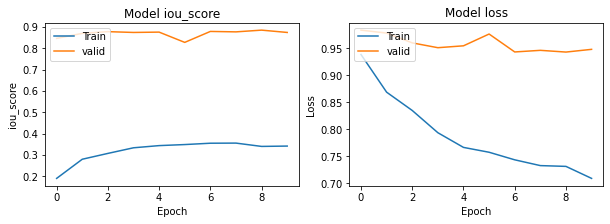

In [100]:
# Plot training & validation iou_score values
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.savefig('training.png')

In [18]:
# load best weights
model.load_weights('./best_model_10epoch.h5')

In [101]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [47]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.96909
mean iou_score: 0.87168
mean f1-score: 0.87531


In [ ]:
n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    print(image.shape)
    visualize(
        image=denormalize(image.squeeze()),
        gt_HC=gt_mask[..., 1].squeeze(),
        pr_HC=pr_mask[..., 1].squeeze(),
        gt_DC=gt_mask[..., 2].squeeze(),
        pr_DC=pr_mask[..., 2].squeeze(),
        gt_hippo=gt_mask[..., 3].squeeze(),
        pr_hippo=pr_mask[..., 3].squeeze(),
    )

In [102]:
from keras import Model

In [79]:
keras.utils.plot_model(model, show_shapes=True)

In [103]:
from keras.layers import Dense, Flatten, MaxPooling2D

In [104]:
inp = model.input
maxpooling = MaxPooling2D(pool_size=(10, 10))
out = maxpooling(model.get_layer("relu1").output)

In [105]:
intermediate_layer_model = Model(inputs=inp,
                                 outputs=out)

In [106]:
import pandas as pd

In [140]:
df = pd.DataFrame()

In [146]:
df = pd.DataFrame()
SAMPLE = "Sample5"
for i, j in enumerate(test_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/test/"+SAMPLE+".csv")

In [147]:
df = pd.DataFrame()
SAMPLE = "Sample6"
for i, j in enumerate(test_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = test_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/test/"+SAMPLE+".csv")

In [148]:
df = pd.DataFrame()
SAMPLE = "Sample1"
for i, j in enumerate(train_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = train_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/train/"+SAMPLE+".csv")

In [149]:
df = pd.DataFrame()
SAMPLE = "Sample2"
for i, j in enumerate(train_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = train_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/train/"+SAMPLE+".csv")

In [150]:
df = pd.DataFrame()
SAMPLE = "Sample3"
for i, j in enumerate(train_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = train_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/train/"+SAMPLE+".csv")

In [152]:
df = pd.DataFrame()
SAMPLE = "Sample4"
for i, j in enumerate(valid_dataset.ids): 
    if j.startswith(SAMPLE):
        image, gt_mask = valid_dataset[i]
        image = np.expand_dims(image, axis=0)
        intermediate_output = intermediate_layer_model.predict(image)
        spot = j.split(".png")[0].split("_")[1]
        df[spot] = intermediate_output.ravel()

df = df.transpose()
df.to_csv("./features/valid/"+SAMPLE+".csv")

In [139]:
train_dataset.ids

['Sample1_789.4-1517.5.png',
 'Sample2_654.1-900.0.png',
 'Sample2_734.4-1176.2.png',
 'Sample1_1302.4-538.7.png',
 'Sample3_562.2-325.3.png',
 'Sample1_1182.2-1558.8.png',
 'Sample2_971.6-1335.0.png',
 'Sample1_1064.2-1558.8.png',
 'Sample1_868.0-1124.6.png',
 'Sample3_1157.3-1226.8.png',
 'Sample2_733.9-1059.3.png',
 'Sample1_946.2-1477.5.png',
 'Sample2_775.4-388.4.png',
 'Sample3_992.8-1268.9.png',
 'Sample1_1260.4-580.3.png',
 'Sample1_1258.5-1088.3.png',
 'Sample2_971.6-1295.9.png',
 'Sample3_962.3-597.8.png',
 'Sample2_891.3-858.6.png',
 'Sample2_810.9-1370.5.png',
 'Sample1_867.3-1009.8.png',
 'Sample3_797.7-1031.1.png',
 'Sample3_1115.1-325.3.png',
 'Sample3_1194.0-1106.3.png',
 'Sample1_1297.0-614.5.png',
 'Sample1_790.5-453.1.png',
 'Sample3_722.6-1306.6.png',
 'Sample1_1183.8-733.1.png',
 'Sample3_485.4-1304.5.png',
 'Sample1_1260.2-339.7.png',
 'Sample2_538.3-506.7.png',
 'Sample1_1179.6-1284.8.png',
 'Sample2_814.8-1255.1.png',
 'Sample1_1381.2-579.9.png',
 'Sample2_691.6